<a href="https://colab.research.google.com/github/GermanOmar/GPs---WAAM/blob/master/WAAM_AM4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Layer geometry prediction in wire arc additive manufacturing: A supervised machine learning approach 


<a href="https://ibb.co/5Rvr5t7"><img src="https://i.ibb.co/kS04hkd/Fig1-4.png" WIDTH="500" HEIGHT="300"  border="0"></a>

 Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing

 Upload database:

In [2]:
!git clone https://github.com/GermanOmar/GPs---WAAM

Cloning into 'GPs---WAAM'...
remote: Enumerating objects: 51, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 51 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (51/51), done.


In [28]:
#Experimental data
data = pd.read_table('df4.txt') 
data.describe()



,V,Q*,PGFR,LH,WW
count,25.00,25.00,25.00,25.00,25.00
mean,22.96,1.42,2.21,1.65,7.45
std,1.16,0.35,1.49,0.22,0.99
min,21.03,0.89,0.80,1.29,5.80
25%,22.13,1.21,0.80,1.51,6.70
50%,23.18,1.34,1.70,1.62,7.35
75%,23.84,1.55,3.16,1.81,8.00
max,24.76,2.30,5.00,2.07,9.50


<a href="https://ibb.co/QrLn5c3"><img src="https://i.ibb.co/XS1pw4r/FIG1-geo.png" WIDTH="500" HEIGHT="325"  border="0"></a>


Setting inputs - output:

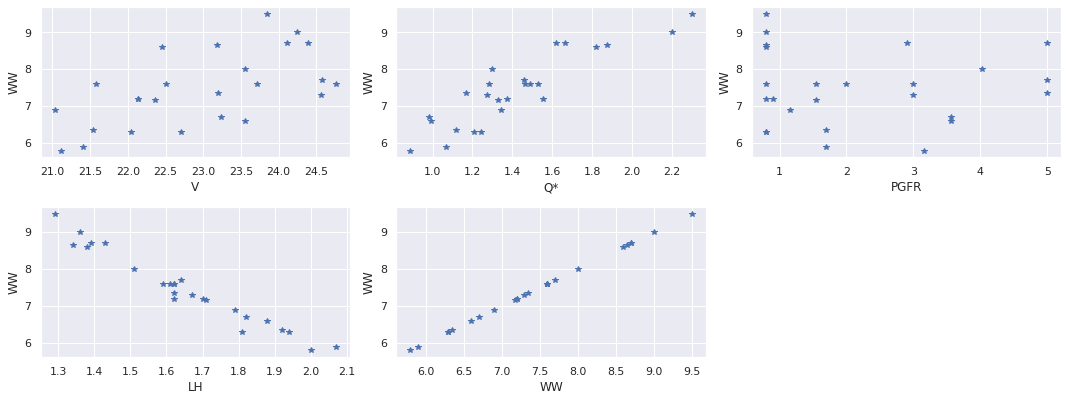

In [29]:
fields = [ 'V', 'Q*','PGFR', 'LH','WW']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['WW'], 'b*')
  plt.xlabel(field)
  plt.ylabel('WW')

plt.tight_layout()

X=data[[ 'V', 'Q*','PGFR']]
Y=data['WW'][:,None]
Z=data['LH'][:,None]


#fig.tight_layout()

NameError: ignored

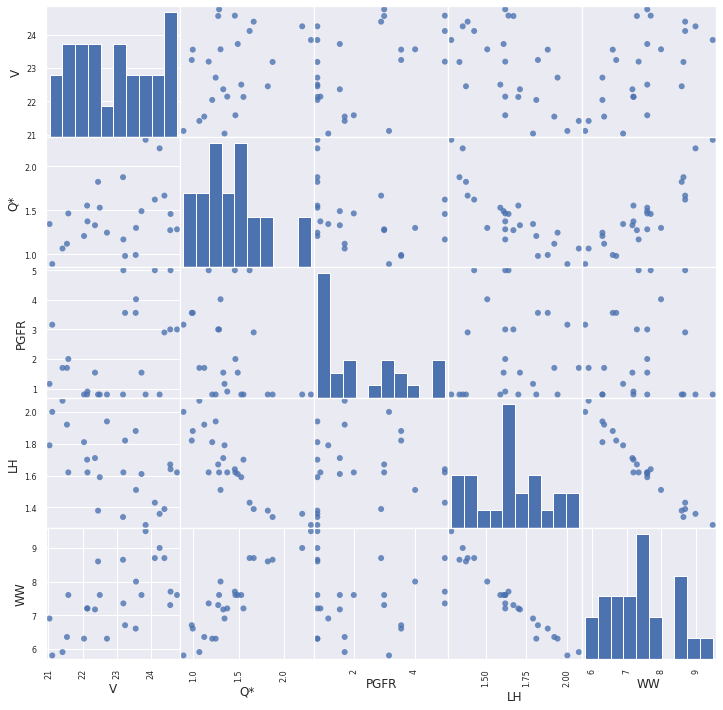

In [30]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
scatter_matrix(data, alpha=0.8, marker='o', figsize = (12,12))
warnings.filterwarnings("ignore")

#Wall width prediction

In [31]:
def normalize(X, X_mu, X_std):
  return (X - X_mu)/X_std

def denormalize(Xn, X_mu, X_std):
  return Xn*X_std + X_mu

X_std = X.std(0)
X_mu = X.mean(0)
Xn = normalize(X, X_mu, X_std)

Y_std = Y.std(0)
Y_mu = Y.mean(0)
Yn = normalize(Y, Y_mu, Y_std)

 Split data

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.22, random_state=32)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 19  test samples: 6


In [33]:
pip install lazypredict

In [34]:
from lazypredict.Supervised import LazyRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import numpy as np

#Results:

In [35]:
from sklearn.metrics import mean_absolute_error as MAE
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

100%|██████████| 39/39 [00:00<00:00, 46.40it/s]

StackingRegressor model failed to execute
__init__() missing 1 required positional argument: 'estimators'
[17:01:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
                               R-Squared  RMSE  Time Taken
Model                                                     
XGBRegressor                        0.90  0.23        0.02
GradientBoostingRegressor           0.88  0.25        0.02
LinearSVR                           0.84  0.29        0.01
SGDRegressor                        0.84  0.29        0.01
AdaBoostRegressor                   0.84  0.29        0.06
PassiveAggressiveRegressor          0.83  0.30        0.01
DecisionTreeRegressor               0.81  0.31        0.01
Ridge                               0.78  0.34        0.01
HuberRegressor                      0.77  0.35        0.01
BayesianRidge                       0.77  0.35        0.01
RidgeCV                             0.77  0.35        0.01


## Gradien boosting regressor

Text(0.5, 1.0, 'Gradient boosting regressor')

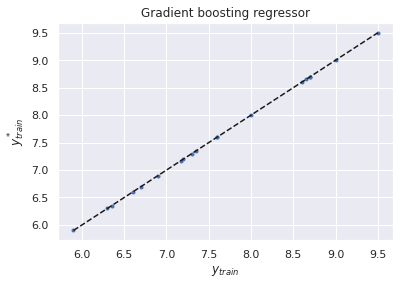

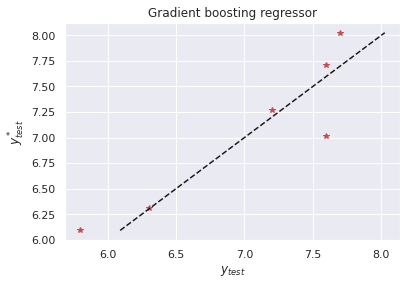

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
#HYPERPARAMETERS

params = {'n_estimators': 3000, 'max_depth': 40, 'min_samples_split': 6, 'max_leaf_nodes': 20,
          'learning_rate': 0.01, 'random_state': 32,'loss': 'ls'}
#KERNEL
model = GradientBoostingRegressor(**params)
#TRAIN
model.fit(X_train,y_train)

#TESTING
y_star_train = model.predict(X_train)
#y_star_val = model1.predict(X_val)
y_pred = model.predict(X_test)

#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'b.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')
plt.title('Gradient boosting regressor')
plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.title('Gradient boosting regressor') 

In [37]:
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)
MSE_train = MSE(y_train, y_star_train)
 
print("-Gradient boosting regressor-")
print("-----------------------------")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-Gradient boosting regressor-
-----------------------------
MSE train: 9.990175312678263e-08
MSE test: 0.09206695201906333
MSE train < MSE test? True

R2_train:  0.9999999010784743
R2:  0.8259238302160568
RMSE:  0.3034253648248006
MAE:  0.2323005787030028
IM:  0.4199202588247697



#GBR 

In [38]:
from sklearn.ensemble import GradientBoostingRegressor
#KERNEL
#GBR=GradientBoostingRegressor(n_estimators=100, random_state=0)
GBR=GradientBoostingRegressor(n_estimators=100, random_state=32, learning_rate=0.1, )

#START TRAINING
GBR.fit(X_train,y_train)
#PREDICTION
y_pred=GBR.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

 
print("-Gradient boosting regressor-")
print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)


-Gradient boosting regressor-
-----------------------------
MSE test: 0.08369853445301507

R2:  0.84174646847119
RMSE:  0.28930698998298515
MAE:  0.2561989226985905
IM:  0.4175890356394352

Relative error (%):  [[ 3.83313775  1.58791124 19.2899817   3.97757047  6.42681256 17.96740632]
 [ 5.19936325  2.92459428 18.22800778  2.71411745  5.19558641 16.88803008]
 [37.8474415  34.86670975  7.14950705 27.478053   24.22647298  8.90533989]
 [11.04377232  8.6426273  13.68511932  2.6906538   0.07132546 12.27069842]
 [ 5.19936325  2.92459428 18.22800778  2.71411745  5.19558641 16.88803008]
 [26.90716837 24.16300263  1.35442208 17.36074721 14.36722909  0.26205895]]


Text(0.5, 1.0, 'Gradient boosting regressor')

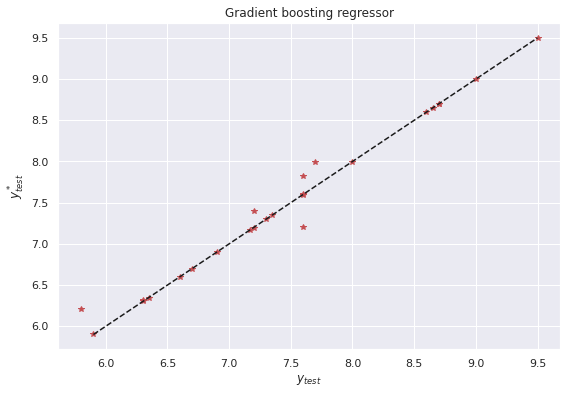

In [39]:
#Plots
y_hat=GBR.predict(X)

fig = plt.figure()
fig.set_size_inches((9,6))

plt.plot(Y, y_hat, 'r*')
plt.plot([y_hat.min(), y_hat.max()], [y_hat.min(), y_hat.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.title('Gradient boosting regressor') 



# GPs

Gaussian Process
MSE train: 0.007536517709069548
MSE test: 0.10479450181391947
MSE train < MSE test? True

R2_train:  0.9925374299518069
R2_test:  0.8018591352257826

R2:  0.8018591352257826
RMSE:  0.32371978903662885
MAE:  0.2713614194232868
IM:  0.46657402848724355



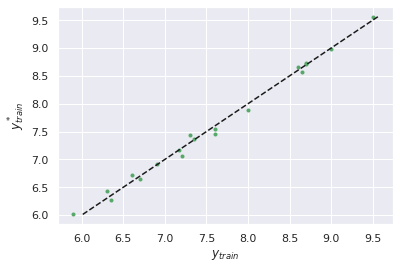

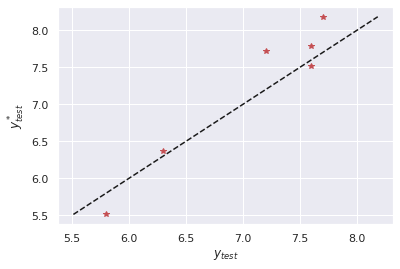

In [40]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
model=GPR(kernel=kernel, n_restarts_optimizer=9, alpha=0.01, normalize_y=True)
 
#Training
model.fit(X_train,y_train)
 
#Testing
y_star_train = model.predict(X_train)
y_pred = model.predict(X_test)
 
#Plots
plt.figure()
plt.plot(y_train, y_star_train, 'g.')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.ylabel('$y^*_{train}$')
plt.xlabel('$y_{train}$')

plt.figure()
plt.plot(y_test, y_pred, 'r*')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

# SGD

In [41]:
from sklearn.linear_model import SGDRegressor

print("-SGD regressor-")
#KERNEL
#SGD=SGDRegressor(random_state=32, max_iter=1000, tol=1e-3, loss='squared_loss', penalty='l2')
from sklearn.ensemble import RandomForestRegressor
#KERNEL
SGD=RandomForestRegressor(n_estimators=500,max_depth=10)


#START TRAINING
SGD.fit(X_train,y_train)
#PREDICTION
y_pred=SGD.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print("-----------------------------")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-SGD regressor-
-----------------------------
MSE test: 0.147361286599992

R2:  0.7213757186134606
RMSE:  0.38387665545066946
MAE:  0.32420999999998684
IM:  0.5745475618938339



# XGB

In [42]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [43]:
print(xgbr)



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [44]:
score = xgbr.score(X_test, y_test)  
print("Training score: ", score)

Training score:  0.8978526441084219


In [45]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

-XGBRegressor -
------------------
MSE test: 0.05402460156043464

R2:  0.8978526441084219
RMSE:  0.23243192887474526
MAE:  0.21932856241861978
IM:  0.3355051447723175



Feature: 0, Score: 0.18462
Feature: 1, Score: 0.76533
Feature: 2, Score: 0.05005


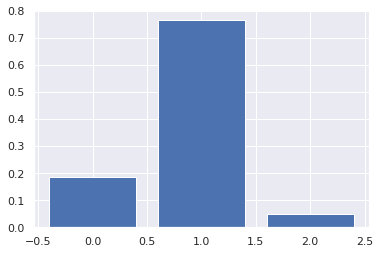

In [46]:
# get importance
importance = xgbr.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# AdaBoost

In [47]:
from sklearn.ensemble import AdaBoostRegressor

print(" AdaBoost -")
print("------------------")

Ada = AdaBoostRegressor(random_state=32, n_estimators=100)
#START TRAINING
Ada.fit(X_train,y_train)
#PREDICTION
y_pred=Ada.predict(X_test)

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

 AdaBoost -
------------------
MSE test: 0.0845281675170068

R2:  0.8401778345266678
RMSE:  0.2907372826401987
MAE:  0.19982142857142873
IM:  0.3872981995955036



## Comparisson

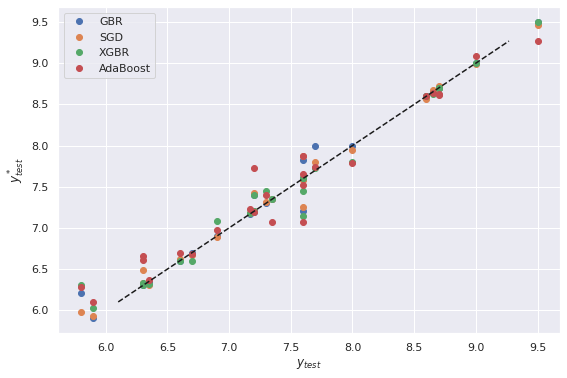

In [48]:
models = [GBR, xgbr, Ada, SGD]
labels = ['GBR', 'SGD', 'XGBR', 'AdaBoost']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X)
  plt.plot(Y, y_pred, 'o' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  